# 102 Flowers Classification

## Goal
This main goal of this notebook is to experimentally evaluate the effectiveness of Transfer Learning according to the amount of available training data and compare it with a train-from-scratch approach in order to assess how much Transfer Learning can actually be useful when very few training examples are available.

## Case study
The experimental case study consists in the classification of flowers images (taken from the [102 Flower Dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html)) into 102 possible categories. 

## Experiments
The flower classification problem is addressed adopting two Transfer Learning techniques: Feature Extraction and Fine-Tuning. The convolutional base used for performing the experiments is a ResNet-50 pre-trained on the ImageNet dataset.

The two approaches are adopted several times varying the size of the training dataset. In particular, the following training set sizes are used: _large_ (6551 examples), _medium_(3275 examples) and _small_(818 examples).


In [ ]:
# (For Colab only)
%tensorflow_version 2.x 
%matplotlib inline

In [ ]:
import numpy as np
import os
import time
import scipy.io as sio
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import seaborn
import pandas as pd

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout, GlobalMaxPool2D

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Constants

In [ ]:
SEED = 42
IMAGES_SIZE = 224
IMAGES_DIR = 'jpg/'
ANNOTATIONS_FILE_PATH = 'imagelabels.mat'
SAVED_MODELS_DIR = 'models/'

BATCH_SIZE = 16
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Fetch and parse data

In [ ]:
!wget "http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"

--2020-06-22 17:56:08--  http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/x-gzip]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  22.2MB/s    in 16s     

2020-06-22 17:56:24 (20.9 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]



In [ ]:
!wget 'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat'

--2020-06-22 17:56:26--  http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502
Saving to: ‘imagelabels.mat’

imagelabels.mat     100%[===================>]     502  --.-KB/s    in 0s      

2020-06-22 17:56:27 (47.8 MB/s) - ‘imagelabels.mat’ saved [502/502]



In [ ]:
!tar xzf '102flowers.tgz'

# Utility classes

In [ ]:
class DataParser: 
    IMAGE_FILES_NAME_PREFIX = 'image_'
    IMAGE_FILES_EXTENSION = '.jpg'

    def __init__(self, annotations_mat_file):
        self.annotations = self._load_annotations(annotations_mat_file)

    def get_image_label(self, image_file_name):
        image_number = self._get_image_number(image_file_name)
        return self.annotations[image_number]

    def _load_annotations(self, annotations_mat_file):
        annotations_mat = sio.loadmat(annotations_mat_file)
        return np.reshape(annotations_mat['labels'], -1)

    def _get_image_number(self, image_file_name):
        image_numer_str = image_file_name.replace(DataParser.IMAGE_FILES_NAME_PREFIX, '').replace(DataParser.IMAGE_FILES_EXTENSION, '')
        return int(image_numer_str.lstrip('0')) - 1

In [ ]:
class ModelTrainer:
  def __init__(self, n_train_examples, n_val_examples, batch_size):
    self.n_train_examples = n_train_examples
    self.n_val_examples = n_val_examples
    self.batch_size = batch_size
    self.train_steps_per_epoch = n_train_examples // batch_size
    self.val_steps_per_epoch = n_val_examples // batch_size

  def train_model(self, model, train_ds, val_ds, epochs, checkpoint_file_path=None, patience=10):
    print("Batch size: {}".format(BATCH_SIZE))
    print("Training dataset size: {} - Training steps per epoch: {}".format(self.n_train_examples, self.train_steps_per_epoch))
    print("Validation dataset size: {} - Validation steps per epoch: {}".format(self.n_val_examples, self.val_steps_per_epoch))

    callbacks = self._get_early_stopping_callbacks(patience, checkpoint_file_path)

    history = model.fit(train_ds,
                        steps_per_epoch=self.train_steps_per_epoch,
                        validation_data=val_ds,
                        validation_steps=self.val_steps_per_epoch,
                        epochs=epochs,
                        callbacks = callbacks)
    
    return history

  def _get_early_stopping_callbacks(self, patience, checkpoint_file_path=None):
    callbacks = []

    if checkpoint_file_path is not None: 
      checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_file_path, save_best_only=True)
      callbacks.append(checkpoint_cb)

    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
    callbacks.append(early_stopping_cb)
    
    return callbacks


In [ ]:
class MyLabelEncoder:
  def __init__(self, labels):
    self.encoder = LabelEncoder()
    self.encoder.fit(labels)

  def encode(self, labels):
    return self.encoder.transform(labels)
  
  def decode(self, labels):
    return self.encoder.inverse_transform(labels)

  def get_labels(self):
    return self.encoder.classes_

# Utility functions for loading and parsing data

In [ ]:
def load_images(images_paths, img_size):
  imgs = []
  
  for path in images_paths:
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    if not img is None: 
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # change color channels order to RGB
      img = cv2.resize(img, (img_size, img_size))
    imgs.append(img)
  
  return np.array(imgs)

In [ ]:
def show_images(images, labels, rows = 1):
    """
    Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    rows (Default = 1): Number of rows in figure (number of cols is 
                        set to np.ceil(n_images/float(rows))).
    
    labels: List of labels corresponding to each image.
    """
    assert(len(images) == len(labels))
    n_images = len(images)
    fig = plt.figure()
    for n, (image, label) in enumerate(zip(images, labels)):
        a = fig.add_subplot(rows, np.ceil(n_images/float(rows)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(label)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()  

# Tensorflow Dataset preparation functions

In [ ]:
def np_to_dataset(np_data, np_labels, training=False, standardization=False, augmentation=False, cache=True, batch_size=32):
  """
  Create a tf dataset from the two numpy arrays provided as argument

  Input params:
  -------------
  np_data: 
    numpy array containing the data (features) records
  np_labels:
    numpy array containing the labels associated to each record of 
    the data dataframe provided as first argument
  training: 
    boolean that indicates if the tf dataset has to be created
    for training purposes (True) or inference purposes (False)
  """
  np_data = np_data.copy()
  ds = tf.data.Dataset.from_tensor_slices((np_data, np_labels))
  ds = ds.map(from_path_to_img, num_parallel_calls=AUTOTUNE)

  if cache:
    ds = ds.cache()
  if training:
    ds = ds.shuffle(buffer_size=len(np_data)).repeat()
  if augmentation:
    ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
  if standardization:
    ds = ds.map(lambda img, label: (tf.image.per_image_standardization(img), label), num_parallel_calls=AUTOTUNE)

  return ds.batch(batch_size).prefetch(AUTOTUNE)

In [ ]:
def from_path_to_img(file_path_tf, label):
  img = tf.io.read_file(file_path_tf)
  img = decode_img(img)
  return (img, label)

In [ ]:
def decode_img(img_tf):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img_tf, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  img = tf.image.resize(img, [IMAGES_SIZE, IMAGES_SIZE])
  return img

In [ ]:
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

In [ ]:
def augment(image, label):
  augmented_image = random_crop(image)
  augmented_image = tf.image.random_flip_left_right(image)
  augmented_image = tf.image.random_flip_up_down(augmented_image)
  augmented_image = tf.image.random_brightness(augmented_image, max_delta=0.2)
  return (augmented_image, label)

# Tensorflow utility functions

In [ ]:
def save_model_weights(model, model_name):
  model_dir = os.path.join(SAVED_MODELS_DIR, model_name)
  checkpoint_path = os.path.join(model_dir, model_name)
  model.save_weights(checkpoint_path)

In [ ]:
def load_model_weights(model, model_name):
  model_dir = os.path.join(SAVED_MODELS_DIR, model_name)
  checkpoint_path = os.path.join(model_dir, model_name)
  model.load_weights(checkpoint_path)

In [ ]:
def freeze_model(model):
  for layer in model.layers:
    layer.trainable = False

# Model performance assessment functions

In [ ]:
def show_scores(model, test_ds, plot_cf_matrix=False):
  y_true = [encoded_label for (_, encoded_label) in test_ds]
  start = time.time()
  Y_pred_prob = model.predict(test_ds, steps=len(y_true))
  Y_pred = np.argmax(Y_pred_prob, axis=1).tolist()
  end = time.time()

  precision_micro = metrics.precision_score(y_pred=Y_pred, y_true=y_true, average='micro')
  precision_macro = metrics.precision_score(y_pred=Y_pred, y_true=y_true, average='macro')
  recall_micro = metrics.recall_score(y_pred=Y_pred, y_true=y_true, average='micro')
  recall_macro = metrics.recall_score(y_pred=Y_pred, y_true=y_true, average='macro')
  f1_micro = metrics.f1_score(y_pred=Y_pred, y_true=y_true, average='micro')
  f1_macro = metrics.f1_score(y_pred=Y_pred, y_true=y_true, average='macro')

  if plot_cf_matrix:
    plt.figure(figsize = (10,7))
    norm_cm = metrics.confusion_matrix(y_true=y_true, y_pred=Y_pred, labels=encoder.get_labels(), normalize='true')
    norm_cm_df = pd.DataFrame(norm_cm, index=encoder.get_labels(), columns=encoder.get_labels())
    seaborn.heatmap(norm_cm_df, annot=True)

  print('|Average prediction time: {:.2f} ms'.format((end-start)/len(y_true)*1000))
  print('|Average Type |Prec |Rec |F1')
  print('|--- |--- |--- |---') 
  print("|{}|{:.2f}|{:.2f}|{:.2f}".format('Micro', precision_micro, recall_micro, f1_micro)) 
  print("|{}|{:.2f}|{:.2f}|{:.2f}".format('Macro', precision_macro, recall_macro, f1_macro))

In [ ]:
def plot_curves(history): 
  plt.figure(figsize=(18,6))
  plt.subplot(1,2,1)
  plot_accuracy_curves(history)
  plt.subplot(1,2,2)
  plot_loss_curves(history)

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy_curves(history):  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
 
  epochs = range(1, len(acc) + 1)
 
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

def plot_loss_curves(history): 

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

# Data loading

Load the images paths and the respective labels

In [ ]:
import glob

dataparser = DataParser('imagelabels.mat')

images = np.asarray(glob.glob('jpg/*.jpg'))
labels = np.asarray([dataparser.get_image_label(os.path.basename(image)) for image in images])

Split the loaded images paths and labels into training, validation and test sets. Stratified sampling is used.

In [ ]:
X_train, X_test, labels_train, labels_test = train_test_split(images, labels, train_size=0.80, random_state=SEED)
X_val, X_test, labels_val, labels_test = train_test_split(X_test, labels_test, train_size=0.75, random_state=SEED)

In [ ]:
print(f'Train size: {X_train.shape}')
print(f'Val size: {X_val.shape}')
print(f'Test size: {X_test.shape}')

Train size: (6551,)
Val size: (1228,)
Test size: (410,)


Plot some of the loaded images and the respective labels

In [ ]:
imgs = load_images(X_train[:10], img_size=IMAGES_SIZE)
show_images(imgs, labels_train[:10], rows=2)

Encoder for fitting labels to the models (using one-hot encoding)

In [ ]:
encoder = MyLabelEncoder(labels)

# Pre-trained Resnet50-v2

In [ ]:
def create_resnet50v2_model():
  conv_base = tf.keras.applications.ResNet50V2(
    include_top=False, 
    weights='imagenet', 
    input_shape=(IMAGES_SIZE, IMAGES_SIZE, 3),
    pooling='avg'
  )
  
  model = Sequential()
  model.add(conv_base)
  model.add(Dense(len(np.unique(labels)), activation='softmax'))

  return model

## Large Training Dataset

In [ ]:
X_train, X_test, labels_train, labels_test = train_test_split(images, labels, train_size=0.80, stratify=labels, random_state=SEED)
X_val, X_test, labels_val, labels_test = train_test_split(X_test, labels_test, train_size=0.75, stratify=labels_test, random_state=SEED)

In [ ]:
y_train = encoder.encode(labels_train)
y_val = encoder.encode(labels_val)
y_test = encoder.encode(labels_test)

In [ ]:
print(f'Train size: {X_train.shape} - {round((len(X_train) * 100)/len(images), 2)}%')
print(f'Val size: {X_val.shape} - {round((len(X_val) * 100)/len(images), 2)}%')
print(f'Test size: {X_test.shape} - {round((len(X_test) * 100)/len(images), 2)}%')

Train size: (6551,) - 80.0%
Val size: (1228,) - 15.0%
Test size: (410,) - 5.01%


In [ ]:
model_trainer = ModelTrainer(len(X_train), len(X_val), BATCH_SIZE)

### Feature extraction **without** data augmentation

In [ ]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=False, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [ ]:
model = create_resnet50v2_model()

94674944/94668760 [==============================] - 1s 0us/step


In [ ]:
conv_base = model.get_layer('resnet50v2')
freeze_model(conv_base)

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 102)               208998    
Total params: 23,773,798
Trainable params: 208,998
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=30)

Batch size: 16
Training dataset size: 6551 - Training steps per epoch: 409
Validation dataset size: 1228 - Validation steps per epoch: 76
Epoch 1/30
409/409 [==============================] - 23s 57ms/step - loss: 3.6673 - accuracy: 0.1985 - val_loss: 2.8176 - val_accuracy: 0.3980
Epoch 2/30
409/409 [==============================] - 21s 51ms/step - loss: 2.1475 - accuracy: 0.5711 - val_loss: 1.9281 - val_accuracy: 0.6201
Epoch 3/30
409/409 [==============================] - 21s 52ms/step - loss: 1.4648 - accuracy: 0.7421 - val_loss: 1.4950 - val_accuracy: 0.7007
Epoch 4/30
409/409 [==============================] - 35s 87ms/step - loss: 1.1000 - accuracy: 0.8238 - val_loss: 1.2424 - val_accuracy: 0.7549
Epoch 5/30
409/409 [==============================] - 35s 86ms/step - loss: 0.8716 - accuracy: 0.8661 - val_loss: 1.0813 - val_accuracy: 0.7895
Epoch 6/30
409/409 [==============================] - 35s 87ms/step - loss: 0.7188 - accuracy: 0.8964 - val_loss: 0.9604 - val_accuracy: 0.808

In [ ]:
save_model(model, 'resnet50v2_fe')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/resnet50v2_fe/assets


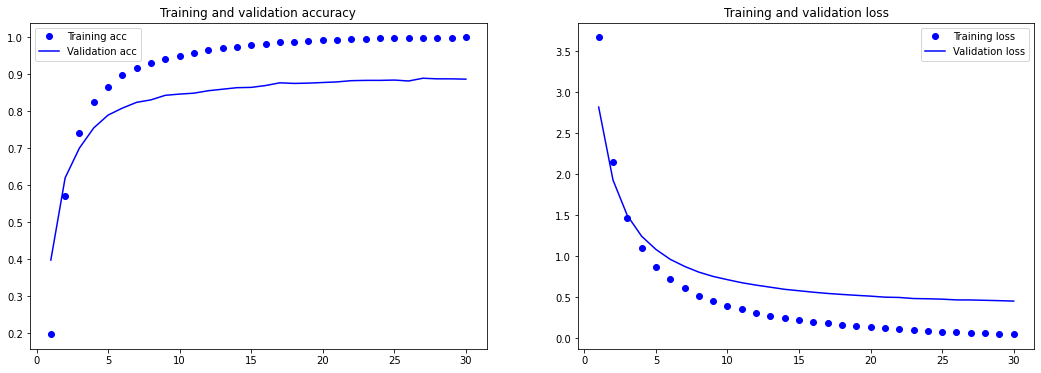

In [ ]:
plot_curves(history)

In [ ]:
show_scores(model, test_ds)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


|Average prediction time: 9.71 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.89|0.89|0.89
|Macro|0.87|0.88|0.86


### Fine-tuning **without** data augmentation

In [ ]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=False, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [ ]:
model = create_resnet50v2_model()
load_model_weights(model, 'resnet50v2_fe')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_2 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 23,728,358
Non-trainable params: 45,440
_________________________________________________________________


Unfreeze block conv_5 and post_bn layer of the convolutional base, as well as the classifier

In [ ]:
conv_base = model.get_layer('resnet50v2')
classifier = model.get_layer('dense_2')

# Freeze convolutional base
freeze_model(conv_base)

# Unfreeze the last few layers of the convolutional base
for layer in conv_base.layers:
  if layer.name.startswith('conv5_block3') or layer.name.startswith('post'):
    layer.trainable = True

In [ ]:
# Compile with lower learning rate
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_2 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 4,677,734
Non-trainable params: 19,096,064
_________________________________________________________________


In [ ]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=100)

Batch size: 16
Training dataset size: 6551 - Training steps per epoch: 409
Validation dataset size: 1228 - Validation steps per epoch: 76
Epoch 1/100
409/409 [==============================] - 62s 151ms/step - loss: 0.3575 - accuracy: 0.9218 - val_loss: 0.5872 - val_accuracy: 0.8660
Epoch 2/100
409/409 [==============================] - 59s 144ms/step - loss: 0.1488 - accuracy: 0.9852 - val_loss: 0.5259 - val_accuracy: 0.8775
Epoch 3/100
409/409 [==============================] - 59s 144ms/step - loss: 0.0983 - accuracy: 0.9931 - val_loss: 0.4901 - val_accuracy: 0.8857
Epoch 4/100
409/409 [==============================] - 77s 189ms/step - loss: 0.0694 - accuracy: 0.9959 - val_loss: 0.4732 - val_accuracy: 0.8840
Epoch 5/100
409/409 [==============================] - 77s 189ms/step - loss: 0.0530 - accuracy: 0.9982 - val_loss: 0.4519 - val_accuracy: 0.8914
Epoch 6/100
409/409 [==============================] - 77s 187ms/step - loss: 0.0403 - accuracy: 0.9988 - val_loss: 0.4415 - val_acc

In [ ]:
save_model_weights(model, 'resnet50v2_ft')

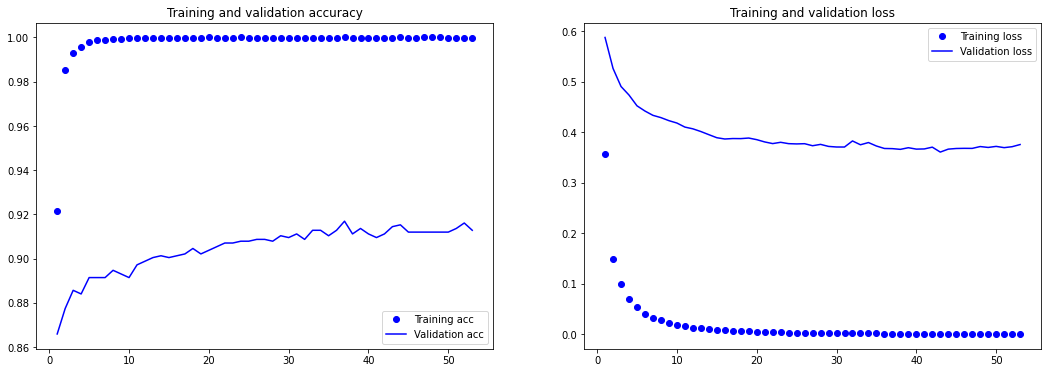

In [ ]:
plot_curves(history)

In [ ]:
show_scores(model, test_ds)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


|Average prediction time: 20.94 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.94|0.94|0.94
|Macro|0.94|0.93|0.92


### Feature extraction **with** Data Augmentation

In [ ]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=True, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [ ]:
model = create_resnet50v2_model()

In [ ]:
conv_base = model.get_layer('resnet50v2')
freeze_model(conv_base)

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_6 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 208,998
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=30)

Batch size: 16
Training dataset size: 6551 - Training steps per epoch: 409
Validation dataset size: 1228 - Validation steps per epoch: 76
Epoch 1/30
409/409 [==============================] - 54s 132ms/step - loss: 3.8180 - accuracy: 0.1840 - val_loss: 2.9462 - val_accuracy: 0.3586
Epoch 2/30
409/409 [==============================] - 51s 125ms/step - loss: 2.3214 - accuracy: 0.5144 - val_loss: 2.0540 - val_accuracy: 0.5987
Epoch 3/30
409/409 [==============================] - 51s 126ms/step - loss: 1.6578 - accuracy: 0.6887 - val_loss: 1.5924 - val_accuracy: 0.6949
Epoch 4/30
409/409 [==============================] - 70s 171ms/step - loss: 1.2803 - accuracy: 0.7660 - val_loss: 1.3157 - val_accuracy: 0.7541
Epoch 5/30
409/409 [==============================] - 70s 170ms/step - loss: 1.0539 - accuracy: 0.8116 - val_loss: 1.1407 - val_accuracy: 0.7722
Epoch 6/30
409/409 [==============================] - 69s 168ms/step - loss: 0.8867 - accuracy: 0.8421 - val_loss: 1.0170 - val_accuracy:

In [ ]:
save_model_weights(model, 'resnet50v2_fe_aug')

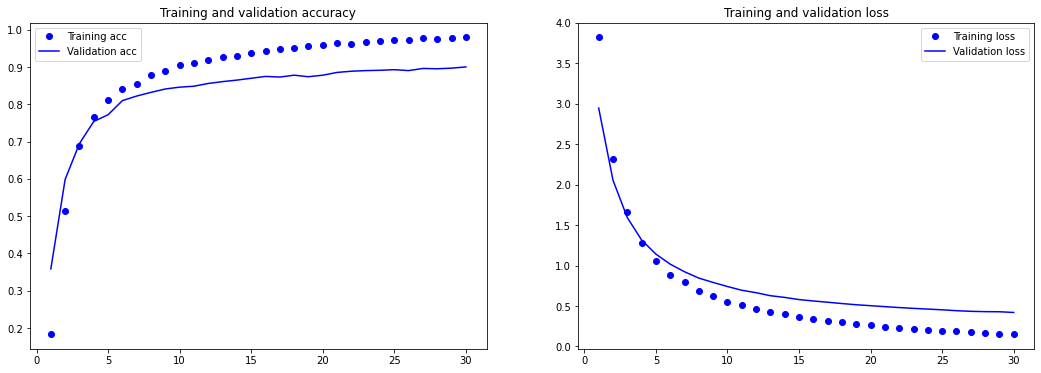

In [ ]:
plot_curves(history)

In [ ]:
show_scores(model, test_ds)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


|Average prediction time: 19.41 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.89|0.89|0.89
|Macro|0.87|0.88|0.86


### Fine-tuning **with** data augmentation


In [ ]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=True, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [ ]:
model = create_resnet50v2_model()
load_model_weights(model, 'resnet50v2_fe_aug')

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_7 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 23,728,358
Non-trainable params: 45,440
_________________________________________________________________


Unfreeze block conv_5 and post_bn layer of the convolutional base, as well as the classifier

In [ ]:
conv_base = model.get_layer('resnet50v2')
classifier = model.get_layer('dense_7')

# Freeze convolutional base
freeze_model(conv_base)

# Unfreeze the last few layers of the convolutional base
for layer in conv_base.layers:
  if layer.name.startswith('conv5_block3') or layer.name.startswith('post'):
    layer.trainable = True

In [ ]:
# Compile with lower learning rate
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_7 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 4,677,734
Non-trainable params: 19,096,064
_________________________________________________________________


In [ ]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=100)

Batch size: 16
Training dataset size: 6551 - Training steps per epoch: 409
Validation dataset size: 1228 - Validation steps per epoch: 76
Epoch 1/100
409/409 [==============================] - 61s 149ms/step - loss: 0.3313 - accuracy: 0.9134 - val_loss: 0.3010 - val_accuracy: 0.9186
Epoch 2/100
409/409 [==============================] - 58s 142ms/step - loss: 0.1064 - accuracy: 0.9754 - val_loss: 0.2503 - val_accuracy: 0.9326
Epoch 3/100
409/409 [==============================] - 58s 143ms/step - loss: 0.0628 - accuracy: 0.9879 - val_loss: 0.2160 - val_accuracy: 0.9391
Epoch 4/100
409/409 [==============================] - 76s 186ms/step - loss: 0.0440 - accuracy: 0.9911 - val_loss: 0.2214 - val_accuracy: 0.9408
Epoch 5/100
409/409 [==============================] - 76s 186ms/step - loss: 0.0322 - accuracy: 0.9942 - val_loss: 0.2101 - val_accuracy: 0.9383
Epoch 6/100
409/409 [==============================] - 76s 185ms/step - loss: 0.0248 - accuracy: 0.9963 - val_loss: 0.2414 - val_acc

In [ ]:
save_model_weights(model, 'resnet50v2_ft_aug')

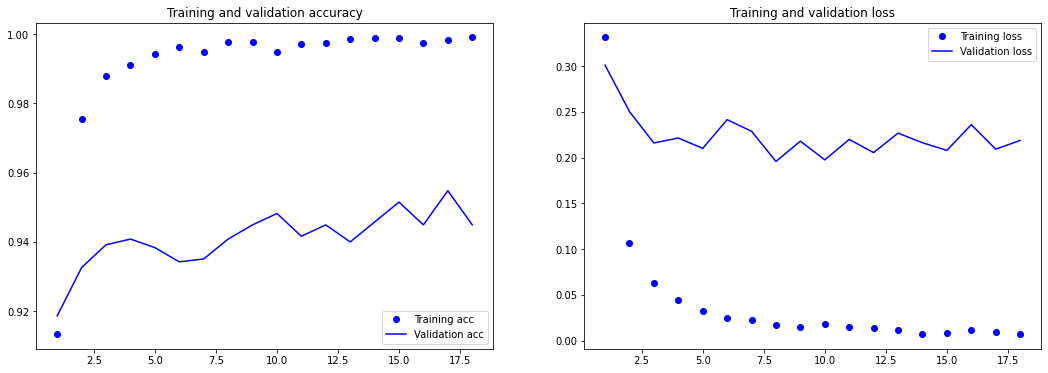

In [ ]:
plot_curves(history)

In [ ]:
show_scores(model, test_ds)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


|Average prediction time: 19.31 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.93|0.93|0.93
|Macro|0.93|0.93|0.92


## Medium training set

In [ ]:
X_train, X_test, labels_train, labels_test = train_test_split(images, labels, train_size=0.40, stratify=labels, random_state=SEED)
X_val, X_test, labels_val, labels_test = train_test_split(X_test, labels_test, train_size=0.50, stratify=labels_test, random_state=SEED)

In [ ]:
y_train = encoder.encode(labels_train)
y_val = encoder.encode(labels_val)
y_test = encoder.encode(labels_test)

In [ ]:
print(f'Train size: {X_train.shape} - {round((len(X_train) * 100)/len(images), 2)}%')
print(f'Val size: {X_val.shape} - {round((len(X_val) * 100)/len(images), 2)}%')
print(f'Test size: {X_test.shape} - {round((len(X_test) * 100)/len(images), 2)}%')

Train size: (3275,) - 39.99%
Val size: (2457,) - 30.0%
Test size: (2457,) - 30.0%


In [ ]:
model_trainer = ModelTrainer(len(X_train), len(X_val), BATCH_SIZE)

### Feature extraction **without** data augmentation

In [ ]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=False, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [ ]:
model = create_resnet50v2_model()

94674944/94668760 [==============================] - 1s 0us/step


In [ ]:
conv_base = model.get_layer('resnet50v2')
freeze_model(conv_base)

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 102)               208998    
Total params: 23,773,798
Trainable params: 208,998
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=30)

Batch size: 16
Training dataset size: 3275 - Training steps per epoch: 204
Validation dataset size: 2457 - Validation steps per epoch: 153
Epoch 1/30
204/204 [==============================] - 18s 88ms/step - loss: 4.2803 - accuracy: 0.0904 - val_loss: 3.5715 - val_accuracy: 0.2075
Epoch 2/30
204/204 [==============================] - 11s 56ms/step - loss: 3.0380 - accuracy: 0.3410 - val_loss: 2.7395 - val_accuracy: 0.4122
Epoch 3/30
204/204 [==============================] - 11s 56ms/step - loss: 2.2804 - accuracy: 0.5463 - val_loss: 2.2096 - val_accuracy: 0.5445
Epoch 4/30
204/204 [==============================] - 11s 56ms/step - loss: 1.7805 - accuracy: 0.6697 - val_loss: 1.8541 - val_accuracy: 0.6209
Epoch 5/30
204/204 [==============================] - 11s 55ms/step - loss: 1.4362 - accuracy: 0.7635 - val_loss: 1.6066 - val_accuracy: 0.6765
Epoch 6/30
204/204 [==============================] - 11s 56ms/step - loss: 1.1965 - accuracy: 0.8192 - val_loss: 1.4278 - val_accuracy: 0.71

In [ ]:
save_model_weights(model, 'resnet50v2_fe')

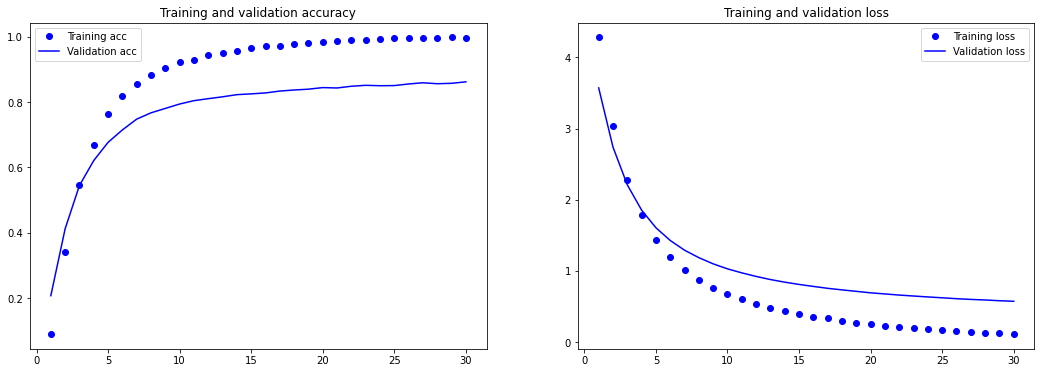

In [ ]:
plot_curves(history)

In [ ]:
show_scores(model, test_ds)

|Average prediction time: 8.30 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.83|0.83|0.83
|Macro|0.86|0.80|0.82


### Fine-tuning **without** data augmentation

In [ ]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=False, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [ ]:
model = create_resnet50v2_model()
load_model_weights(model, 'resnet50v2_fe')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_1 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 23,728,358
Non-trainable params: 45,440
_________________________________________________________________


Unfreeze block conv_5 and post_bn layer of the convolutional base, as well as the classifier

In [ ]:
conv_base = model.get_layer('resnet50v2')
classifier = model.get_layer('dense_1')

# Freeze convolutional base
freeze_model(conv_base)

# Unfreeze the last few layers of the convolutional base
for layer in conv_base.layers:
  if layer.name.startswith('conv5_block3') or layer.name.startswith('post'):
    layer.trainable = True

In [ ]:
# Compile with lower learning rate
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_1 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 4,677,734
Non-trainable params: 19,096,064
_________________________________________________________________


In [ ]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=100)

Batch size: 16
Training dataset size: 3275 - Training steps per epoch: 204
Validation dataset size: 2457 - Validation steps per epoch: 153
Epoch 1/100
204/204 [==============================] - 18s 90ms/step - loss: 0.3324 - accuracy: 0.9280 - val_loss: 0.4408 - val_accuracy: 0.8832
Epoch 2/100
204/204 [==============================] - 17s 85ms/step - loss: 0.0264 - accuracy: 0.9985 - val_loss: 0.3499 - val_accuracy: 0.9016
Epoch 3/100
204/204 [==============================] - 12s 60ms/step - loss: 0.0103 - accuracy: 0.9997 - val_loss: 0.3360 - val_accuracy: 0.9077
Epoch 4/100
204/204 [==============================] - 12s 60ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.3259 - val_accuracy: 0.9122
Epoch 5/100
204/204 [==============================] - 12s 60ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.3267 - val_accuracy: 0.9134
Epoch 6/100
204/204 [==============================] - 12s 59ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.3288 - val_accuracy

In [ ]:
save_model_weights(model, 'resnet50v2_ft')

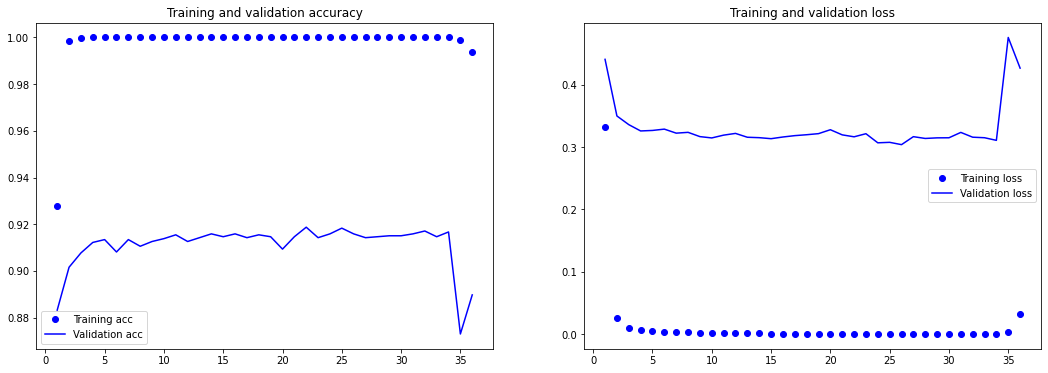

In [ ]:
plot_curves(history)

In [ ]:
show_scores(model, test_ds)

|Average prediction time: 8.10 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.91|0.91|0.91
|Macro|0.91|0.89|0.90


### Feature extraction **with** Data Augmentation

In [ ]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=True, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [ ]:
model = create_resnet50v2_model()

In [ ]:
conv_base = model.get_layer('resnet50v2')
freeze_model(conv_base)

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_2 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 208,998
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=30)

Batch size: 16
Training dataset size: 3275 - Training steps per epoch: 204
Validation dataset size: 2457 - Validation steps per epoch: 153
Epoch 1/30
204/204 [==============================] - 17s 82ms/step - loss: 4.3303 - accuracy: 0.0913 - val_loss: 3.5966 - val_accuracy: 0.1957
Epoch 2/30
204/204 [==============================] - 11s 55ms/step - loss: 3.1569 - accuracy: 0.2840 - val_loss: 2.8151 - val_accuracy: 0.3897
Epoch 3/30
204/204 [==============================] - 11s 55ms/step - loss: 2.4277 - accuracy: 0.4822 - val_loss: 2.3019 - val_accuracy: 0.5204
Epoch 4/30
204/204 [==============================] - 11s 55ms/step - loss: 1.9726 - accuracy: 0.6143 - val_loss: 1.9587 - val_accuracy: 0.6021
Epoch 5/30
204/204 [==============================] - 11s 55ms/step - loss: 1.6418 - accuracy: 0.7047 - val_loss: 1.7118 - val_accuracy: 0.6417
Epoch 6/30
204/204 [==============================] - 11s 54ms/step - loss: 1.4027 - accuracy: 0.7555 - val_loss: 1.5324 - val_accuracy: 0.68

In [ ]:
save_model_weights(model, 'resnet50v2_fe_aug')

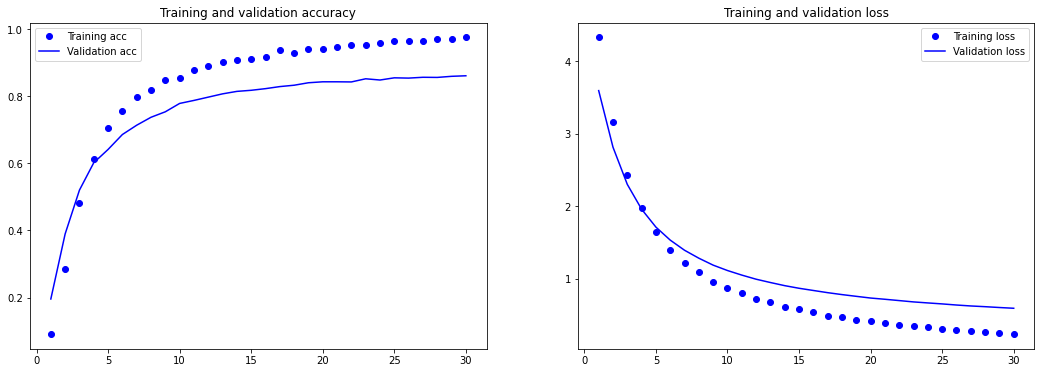

In [ ]:
plot_curves(history)

In [ ]:
show_scores(model, test_ds)

|Average prediction time: 8.06 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.84|0.84|0.84
|Macro|0.85|0.82|0.83


### Fine-tuning **with** data augmentation


In [ ]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=True, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [ ]:
model = create_resnet50v2_model()
load_model_weights(model, 'resnet50v2_fe_aug')

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_3 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 23,728,358
Non-trainable params: 45,440
_________________________________________________________________


Unfreeze block conv_5 and post_bn layer of the convolutional base, as well as the classifier

In [ ]:
conv_base = model.get_layer('resnet50v2')
classifier = model.get_layer('dense_3')

# Freeze convolutional base
freeze_model(conv_base)

# Unfreeze the last few layers of the convolutional base
for layer in conv_base.layers:
  if layer.name.startswith('conv5_block3') or layer.name.startswith('post'):
    layer.trainable = True

In [ ]:
# Compile with lower learning rate
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_3 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 4,677,734
Non-trainable params: 19,096,064
_________________________________________________________________


In [ ]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=100)

Batch size: 16
Training dataset size: 3275 - Training steps per epoch: 204
Validation dataset size: 2457 - Validation steps per epoch: 153
Epoch 1/100
204/204 [==============================] - 18s 88ms/step - loss: 0.4812 - accuracy: 0.8790 - val_loss: 0.4764 - val_accuracy: 0.8668
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - loss: 0.1345 - accuracy: 0.9761 - val_loss: 0.3670 - val_accuracy: 0.8942
Epoch 3/100
204/204 [==============================] - 12s 59ms/step - loss: 0.0728 - accuracy: 0.9871 - val_loss: 0.3236 - val_accuracy: 0.9069
Epoch 4/100
204/204 [==============================] - 12s 59ms/step - loss: 0.0514 - accuracy: 0.9899 - val_loss: 0.3380 - val_accuracy: 0.9003
Epoch 5/100
204/204 [==============================] - 12s 59ms/step - loss: 0.0301 - accuracy: 0.9972 - val_loss: 0.3262 - val_accuracy: 0.9105
Epoch 6/100
204/204 [==============================] - 12s 58ms/step - loss: 0.0340 - accuracy: 0.9942 - val_loss: 0.3272 - val_accuracy

In [ ]:
save_model_weights(model, 'resnet50v2_ft_aug')

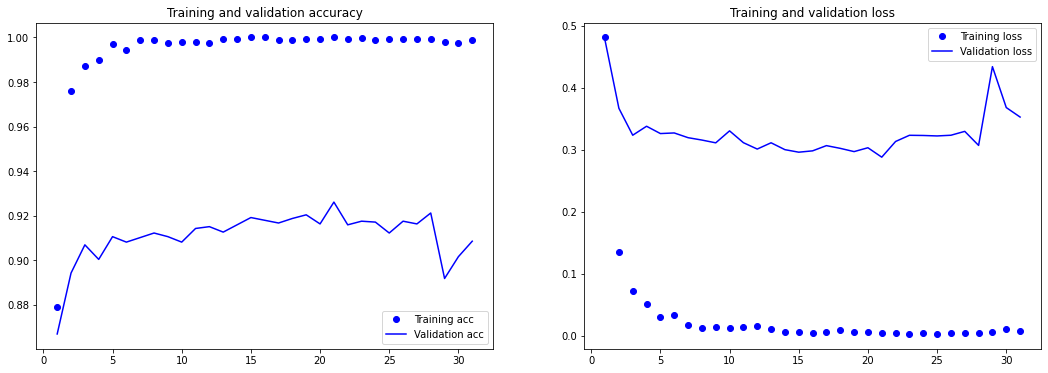

In [ ]:
plot_curves(history)

In [ ]:
show_scores(model, test_ds)

|Average prediction time: 8.04 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.92|0.92|0.92
|Macro|0.92|0.91|0.91


## Small training set

In [ ]:
X_train, X_test, labels_train, labels_test = train_test_split(images, labels, train_size=0.10, random_state=SEED, stratify=labels)
X_val, X_test, labels_val, labels_test = train_test_split(X_test, labels_test, train_size=0.333, random_state=SEED, stratify=labels_test)

In [ ]:
y_train = encoder.encode(labels_train)
y_val = encoder.encode(labels_val)
y_test = encoder.encode(labels_test)

In [ ]:
print(f'Train size: {X_train.shape} - {round((len(X_train) * 100)/len(images), 2)}%')
print(f'Val size: {X_val.shape} - {round((len(X_val) * 100)/len(images), 2)}%')
print(f'Test size: {X_test.shape} - {round((len(X_test) * 100)/len(images), 2)}%')

Train size: (818,) - 9.99%
Val size: (2454,) - 29.97%
Test size: (4917,) - 60.04%


In [ ]:
model_trainer = ModelTrainer(len(X_train), len(X_val), BATCH_SIZE)

### Feature extraction **without** data augmentation

In [ ]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=False, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [ ]:
model = create_resnet50v2_model()

94674944/94668760 [==============================] - 1s 0us/step


In [ ]:
conv_base = model.get_layer('resnet50v2')
freeze_model(conv_base)

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 102)               208998    
Total params: 23,773,798
Trainable params: 208,998
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=30)

Batch size: 16
Training dataset size: 818 - Training steps per epoch: 51
Validation dataset size: 2454 - Validation steps per epoch: 153
Epoch 1/30
51/51 [==============================] - 12s 231ms/step - loss: 4.8861 - accuracy: 0.0257 - val_loss: 4.5056 - val_accuracy: 0.0560
Epoch 2/30
51/51 [==============================] - 9s 181ms/step - loss: 4.2052 - accuracy: 0.0748 - val_loss: 4.0834 - val_accuracy: 0.1127
Epoch 3/30
51/51 [==============================] - 9s 183ms/step - loss: 3.7221 - accuracy: 0.1630 - val_loss: 3.7509 - val_accuracy: 0.1724
Epoch 4/30
51/51 [==============================] - 9s 183ms/step - loss: 3.3004 - accuracy: 0.2598 - val_loss: 3.4663 - val_accuracy: 0.2292
Epoch 5/30
51/51 [==============================] - 9s 185ms/step - loss: 2.9388 - accuracy: 0.3542 - val_loss: 3.2196 - val_accuracy: 0.2745
Epoch 6/30
51/51 [==============================] - 9s 186ms/step - loss: 2.6188 - accuracy: 0.4657 - val_loss: 3.0052 - val_accuracy: 0.3280
Epoch 7/30

In [ ]:
save_model_weights(model, 'resnet50v2_fe')

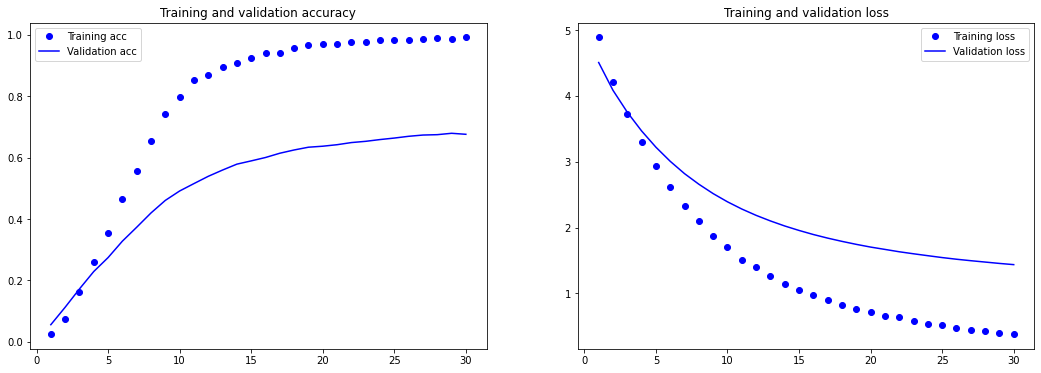

In [ ]:
plot_curves(history)

In [ ]:
show_scores(model, test_ds)

|Average prediction time: 7.01 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.68|0.68|0.68
|Macro|0.73|0.62|0.64


### Fine-tuning **without** data augmentation

In [ ]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=False, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [ ]:
model = create_resnet50v2_model()
load_model_weights(model, 'resnet50v2_fe')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_1 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 23,728,358
Non-trainable params: 45,440
_________________________________________________________________


Unfreeze block conv_5 and post_bn layer of the convolutional base, as well as the classifier

In [ ]:
conv_base = model.get_layer('resnet50v2')
classifier = model.get_layer('dense_1')

# Freeze convolutional base
freeze_model(conv_base)

# Unfreeze the last few layers of the convolutional base
for layer in conv_base.layers:
  if layer.name.startswith('conv5_block3') or layer.name.startswith('post'):
    layer.trainable = True

In [ ]:
# Compile with lower learning rate
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_1 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 4,677,734
Non-trainable params: 19,096,064
_________________________________________________________________


In [ ]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=100)

Batch size: 16
Training dataset size: 818 - Training steps per epoch: 51
Validation dataset size: 2454 - Validation steps per epoch: 153
Epoch 1/100
51/51 [==============================] - 12s 240ms/step - loss: 0.7869 - accuracy: 0.8591 - val_loss: 1.2760 - val_accuracy: 0.6712
Epoch 2/100
51/51 [==============================] - 10s 198ms/step - loss: 0.0463 - accuracy: 1.0000 - val_loss: 0.9834 - val_accuracy: 0.7357
Epoch 3/100
51/51 [==============================] - 10s 199ms/step - loss: 0.0159 - accuracy: 1.0000 - val_loss: 0.8825 - val_accuracy: 0.7688
Epoch 4/100
51/51 [==============================] - 10s 200ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.8651 - val_accuracy: 0.7729
Epoch 5/100
51/51 [==============================] - 10s 196ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.8669 - val_accuracy: 0.7704
Epoch 6/100
51/51 [==============================] - 10s 197ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.8645 - val_accuracy: 0.7761

In [ ]:
save_model_weights(model, 'resnet50v2_ft')

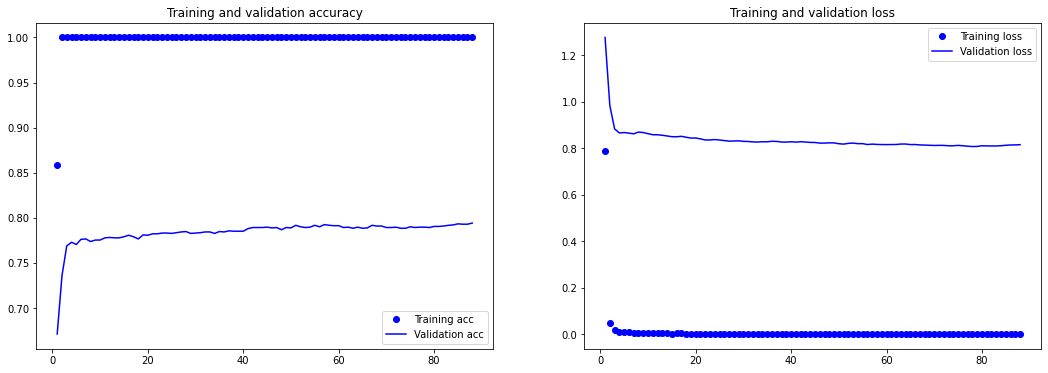

In [ ]:
plot_curves(history)

In [ ]:
show_scores(model, test_ds)

|Average prediction time: 6.93 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.79|0.79|0.79
|Macro|0.81|0.75|0.77


### Feature extraction **with** Data Augmentation

In [ ]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=True, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [ ]:
model = create_resnet50v2_model()

In [ ]:
conv_base = model.get_layer('resnet50v2')
freeze_model(conv_base)

conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_2 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 208,998
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=30)

Batch size: 16
Training dataset size: 818 - Training steps per epoch: 51
Validation dataset size: 2454 - Validation steps per epoch: 153
Epoch 1/30
51/51 [==============================] - 11s 223ms/step - loss: 5.1618 - accuracy: 0.0282 - val_loss: 4.7602 - val_accuracy: 0.0486
Epoch 2/30
51/51 [==============================] - 9s 184ms/step - loss: 4.4966 - accuracy: 0.0637 - val_loss: 4.3408 - val_accuracy: 0.0760
Epoch 3/30
51/51 [==============================] - 9s 185ms/step - loss: 4.0454 - accuracy: 0.1189 - val_loss: 4.0055 - val_accuracy: 0.1189
Epoch 4/30
51/51 [==============================] - 10s 186ms/step - loss: 3.6337 - accuracy: 0.1949 - val_loss: 3.7214 - val_accuracy: 0.1712
Epoch 5/30
51/51 [==============================] - 10s 188ms/step - loss: 3.3015 - accuracy: 0.2659 - val_loss: 3.4684 - val_accuracy: 0.2259
Epoch 6/30
51/51 [==============================] - 10s 188ms/step - loss: 3.0296 - accuracy: 0.3419 - val_loss: 3.2471 - val_accuracy: 0.2815
Epoch 7

In [ ]:
save_model_weights(model, 'resnet50v2_fe_aug')

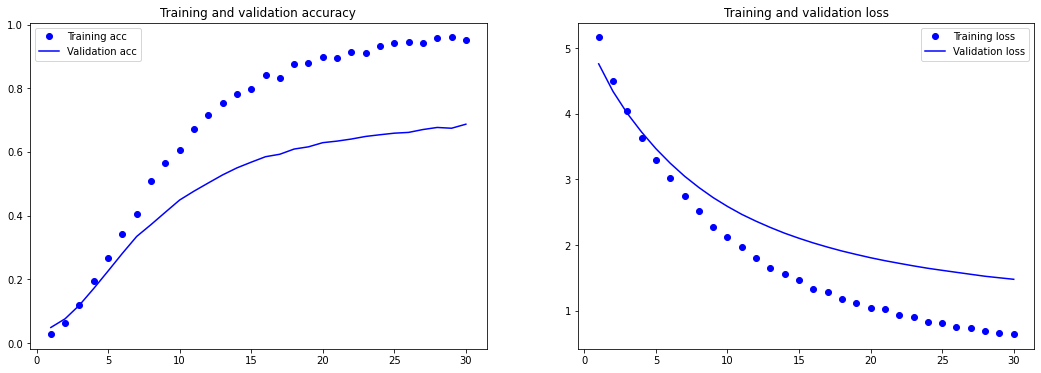

In [ ]:
plot_curves(history)

In [ ]:
show_scores(model, test_ds)

|Average prediction time: 6.91 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.68|0.68|0.68
|Macro|0.72|0.63|0.64


### Fine-tuning **with** data augmentation


In [ ]:
train_ds = np_to_dataset(X_train, y_train, training=True, augmentation=True, batch_size=BATCH_SIZE)
val_ds = np_to_dataset(X_val, y_val, training=False, batch_size=BATCH_SIZE)
test_ds = np_to_dataset(X_test, y_test, training=False, batch_size=1)

In [ ]:
model = create_resnet50v2_model()
load_model_weights(model, 'resnet50v2_fe_aug')

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_3 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 23,728,358
Non-trainable params: 45,440
_________________________________________________________________


Unfreeze block conv_5 and post_bn layer of the convolutional base, as well as the classifier

In [ ]:
conv_base = model.get_layer('resnet50v2')
classifier = model.get_layer('dense_3')

# Freeze convolutional base
freeze_model(conv_base)

# Unfreeze the last few layers of the convolutional base
for layer in conv_base.layers:
  if layer.name.startswith('conv5_block3') or layer.name.startswith('post'):
    layer.trainable = True

In [ ]:
# Compile with lower learning rate
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_3 (Dense)              (None, 102)               208998    
Total params: 23,773,798
Trainable params: 4,677,734
Non-trainable params: 19,096,064
_________________________________________________________________


In [ ]:
history = model_trainer.train_model(model, train_ds, val_ds, epochs=100)

Batch size: 16
Training dataset size: 818 - Training steps per epoch: 51
Validation dataset size: 2454 - Validation steps per epoch: 153
Epoch 1/100
51/51 [==============================] - 12s 240ms/step - loss: 1.0518 - accuracy: 0.7819 - val_loss: 1.4180 - val_accuracy: 0.6430
Epoch 2/100
51/51 [==============================] - 10s 194ms/step - loss: 0.2638 - accuracy: 0.9559 - val_loss: 0.9504 - val_accuracy: 0.7390
Epoch 3/100
51/51 [==============================] - 10s 195ms/step - loss: 0.1269 - accuracy: 0.9828 - val_loss: 0.8434 - val_accuracy: 0.7717
Epoch 4/100
51/51 [==============================] - 10s 196ms/step - loss: 0.0789 - accuracy: 0.9914 - val_loss: 0.8099 - val_accuracy: 0.7831
Epoch 5/100
51/51 [==============================] - 10s 196ms/step - loss: 0.0546 - accuracy: 0.9975 - val_loss: 0.7855 - val_accuracy: 0.7941
Epoch 6/100
51/51 [==============================] - 10s 195ms/step - loss: 0.0411 - accuracy: 0.9975 - val_loss: 0.7631 - val_accuracy: 0.7941

In [ ]:
save_model_weights(model, 'resnet50v2_ft_aug')

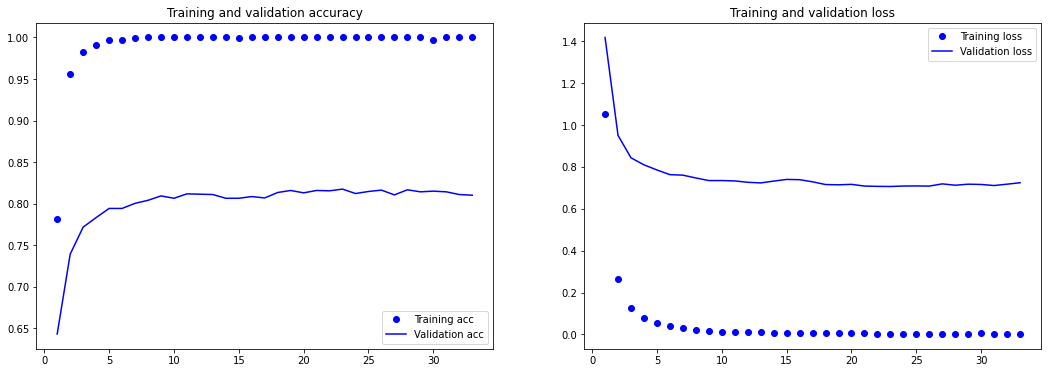

In [ ]:
plot_curves(history)

In [ ]:
show_scores(model, test_ds)

|Average prediction time: 6.92 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.81|0.81|0.81
|Macro|0.82|0.78|0.79
